In [1]:
from IPython.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

20035
/media/work/docs/codes/QuCF/scripts-py


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pylib.mix as mix
from matplotlib import ticker
import time

path_ = "../results/KIN1D1D-results/"
colors_     = ['b', 'r',  'g', 'gray', 'orange']
line_styles = ['-', '--', '--',    '-',     '-']

# cmap = 'seismic'
# cmap = 'bwr'
# cmap = 'jet'
# cmap = 'coolwarm'
cmap_one_sign_ = 'YlGn'
cmap_two_signs_= 'coolwarm'
def fmt_(x, pos):
    a, b = '{:.3e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [4]:
# ---------------------------------------------------
# --- For reading results ---
# ---------------------------------------------------
def read_results(path, fname_loc):
    dd = {}
    fname = path + "/" + fname_loc
    dd["fname"] = fname
    
    print(f"Reading the file {fname}...")
    with h5py.File(fname, "r") as f:
        # ---
        bg           = f["basic"]
        date_sim    = bg["date-of-simulation"][()].decode("utf-8")
        # ---
        bg = f["parameters"]
        w = bg["w"][()]
        xs  = bg["source_x0"][()]
        dxs = bg["source_dx"][()] 
        # ---
        bg = f["grids"]
        x = np.array(bg["x"])
        v = np.array(bg["v"])
        Nx = len(x)
        Nv = len(v)
        # ---
        bg = f["result"]
        psi = np.array(bg["psi"])

    print("date of the simulation: ", date_sim)
        
    print("Nx, Nv: {:d}, {:d}".format(Nx,Nv))

    N_var = Nx*Nv
    dd["g"] = np.zeros((Nx,Nv), dtype=complex)
    dd["E"] = np.zeros(Nx, dtype=complex)
    for ix in range(Nx):
        vE = psi[ix*Nv + N_var]
        dd["E"][ix] = complex(vE[0], vE[1])
        for iv in range(Nv):
            vg = psi[ix*Nv+iv]
            dd["g"][ix,iv] = complex(vg[0], vg[1])
            
    dd.update({
        "x": x, "v": v,
        "x0": xs, "ds": dxs,
        "Nx": Nx, "Nv": Nv,
        "nx": int(np.log2(Nx)), "nv": int(np.log2(Nv)),
        "w": w, 
        "source-x0": xs, "source-dx": dxs
    })
    return dd

In [18]:
# ---------------------------------------------------
# --- Read results ---
# ---------------------------------------------------
dd, line_add, label_fig, name_save = read_results(path_, "w08/out_9_8_w0.8_Lx100_Lv4_flat.hdf5"), "\omega_0 = 0.8", "(a)", "fig-gxv-w08-98-woD.png"
dd, line_add, label_fig, name_save = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"), "\omega_0 = 1.2", "(b)", "fig-gxv-w12-98-woD.png" 
dd, line_add, label_fig, name_save = read_results(path_, "w12/out_7_5_w1.2_Lx100_Lv4_flat.hdf5"), "\eta = 0.0", "(a)", "fig-gxv-w12-75-woD.png" 
dd, line_add, label_fig, name_save = read_results(path_, "out_7_5_w1.2_Lx100_Lv4_flat.hdf5"), "\eta = -0.002", "(b)", "fig-gxv-w12-75-wD.png" 

Reading the file ../results/KIN1D1D-results//w08/out_9_8_w0.8_Lx100_Lv4_flat.hdf5...
date of the simulation:  05-03-2023 12:25:03
Nx, Nv: 512, 256
Reading the file ../results/KIN1D1D-results//w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  10-06-2023 20:13:00
Nx, Nv: 512, 256
Reading the file ../results/KIN1D1D-results//w12/out_7_5_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  10-06-2023 20:04:43
Nx, Nv: 128, 32
Reading the file ../results/KIN1D1D-results//out_7_5_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  08-10-2023 13:00:19
Nx, Nv: 128, 32


In [19]:
# -----------------------------------------------------------------
# --- For plotting ---
# -----------------------------------------------------------------
def plot_results_one(dd):
    fig_gxv_re, fig_gxv_im = None, None
    
    dv = np.diff(dd["v"])[0]
    
    # --- distribution function ---
    XX, YY = np.meshgrid(dd["v"], dd["x"]-dd["x0"])
    
    label_size = 30
    num_size = 25
    fig_x_size = 10
    fig_y_size = 8
    
    
    # -------------- Re g ------------------------------------
    fig_gxv_re = plt.figure(figsize=(fig_x_size, fig_y_size))
    ax = fig_gxv_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(dd["g"]/dv), levels=100, cmap=cmap_two_signs_)
    cbar = fig_gxv_re.colorbar(cs, ax = ax)
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_xlabel('$v$',     fontsize = label_size)
    ax.set_ylabel('$x-x_0$', fontsize = label_size)

    font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': label_size,
        }
    ax.text(-3.0, 40, r'${\rm Re}(g/\Delta v)$', fontdict=font)
    ax.text(-3.0, 30, r'$' + line_add + '$', fontdict=font)
    ax.text(3.2, -46, r'$' + label_fig + '$', fontdict=font)
    
    ax.tick_params(length = 8, width = 2, direction='in', labelsize=num_size)
    cbar.ax.tick_params(length = 8, width = 2, direction='in', labelsize=num_size)
    cbar.ax.yaxis.get_offset_text().set(size=num_size)
    
    return fig_gxv_re, fig_gxv_im

<IPython.core.display.Javascript object>


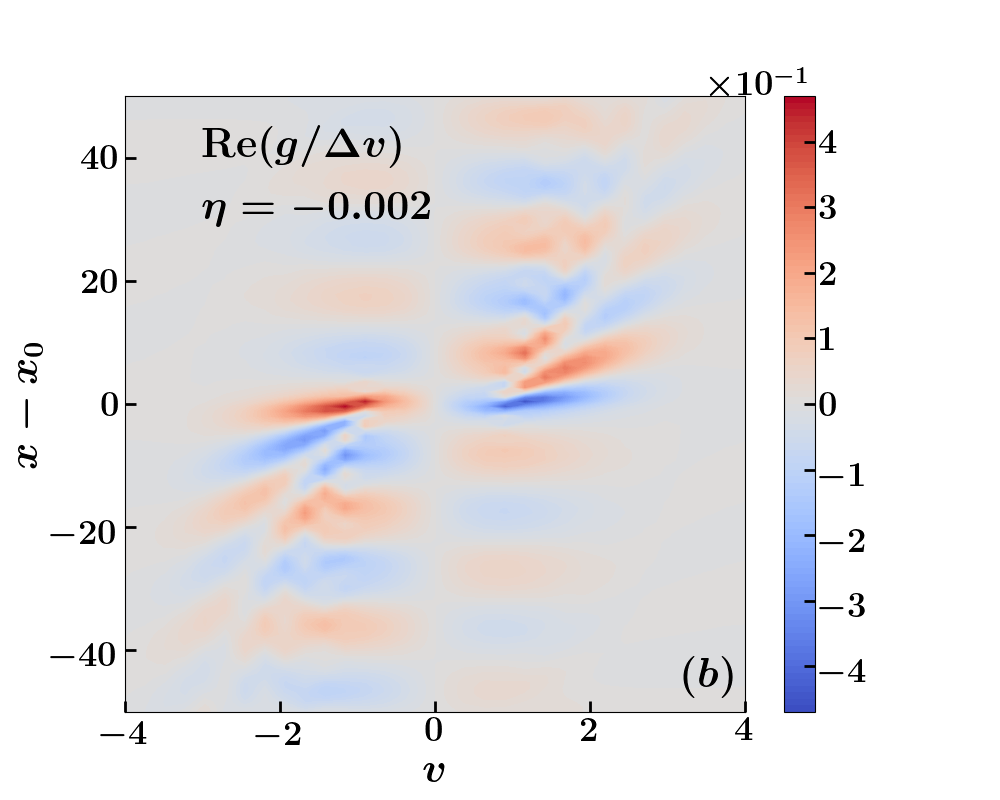

In [20]:
# ---------------------------------------------------
# --- one sim.: g[x,v], E(x) ---
# ---------------------------------------------------
fig_gxv_re, _ = plot_results_one(dd)

In [21]:
# ---------------------------------------------------
# --- Save plots---
# ---------------------------------------------------
folder_to_save = '/media/work/docs/codes/QuCF/results/KIN1D1D-results/figs/'

fig_gxv_re.savefig(folder_to_save + "/" + name_save)